# Function learning notes

In [1]:
from ABCD import GP
from ABCD.kernels import*
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### The main problem I've been working on is how to represent cases in which people seem to learn the target function for the most part but still assign some small probability to the positive linear function.

### Input:

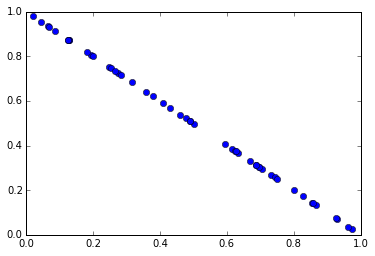

In [2]:
X=np.random.rand(50)
Y=-X.copy()+1
plt.plot(X,Y,'bo')
plt.show()

### Expected output:

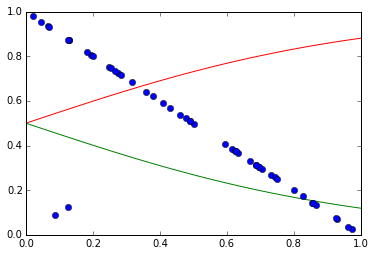

In [3]:
def sig(x,p0,p1):
    return .5*(1+np.tanh((p0-x)/p1))

def prob_cp(f1,f2,p0,p1,x):
    ratio=[sig(x,p0,p1),1-sig(x,p0,p1)]
    if uniform(0,1)<max(ratio):
        index=ratio.index(max(ratio))
    else:
        index=ratio.index(min(ratio))
    if index==1:
        return f1(x)
    else:
        return f2(x)
    
testY=[prob_cp(lambda x:-x+1,lambda x:x,0,.1,x) for x in X]
f1w=np.array([sig(i,0,1) for i in np.linspace(0,1)])
f2w=1-f1w
plt.plot(np.linspace(0,1),f1w,'g')
plt.plot(np.linspace(0,1),f2w,'r')
plt.plot(X,testY,'bo')
plt.show()

#### The change point kernel used by Lloyd et al. (2014) uses a sigmoid function to assign weights to two kernels. The behavior described above can be simulated by modifying this function to return probabilities instead of weights. In this case the positive and negative linear functions begin with equal probabilites, but as x increases the probability assigned to the negative function (red) increases and the probability assigned to the positive function (green) decreases.

#### The change point kernel CP(k1,k2,x1,x2) I use first probabilistically assigns each x to either k1 or k2 with probabilities given by the sigmoid function. CP(k1,k2,x1,x2)=k1(x1,x2) or k2(x1,x2) if x1 and x2 are assigned to the same kernel, else CP(k1,k2,x1,x2)=0.

### Output:

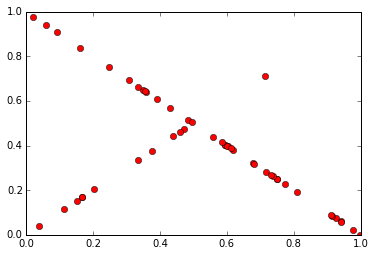

In [4]:
prob_cp_kern=Add(Prob(Linear(mean_args=[0,1]),Linear(mean_args=[1,-1])),RandomNoise())
prob=GP(X,Y,prob_cp_kern)
testX=np.random.rand(50)
testY=[prob.prediction(x) for x in testX]
plt.plot(testX,testY,'ro')
plt.show()

#### If I'm understanding this correctly this would be the same as having two seperate gp's, with each using only the x values assigned to their respective kernels, which I don't think is what we want. When I ran it this final time it actually ended up looking pretty good, but usaully more predictions are made along the positive function and the negative function has a larger slope. I'm also not sure what implications this approach has for scoring each model. The way I'm currently setting up the pcfg is to set the probability of each production rule as the product of the priors assigned to each base kernel, so that P(PLcpNL)=P(PL+NL)=P(PLxNL). Because the score of each model is the product of its marginal likelihood and its production probability given the grammar, kernels constructed from the same base kernels will have scores determined only by their marginal likelihoods. 

In [5]:
add_kern=Add(Add(Linear(mean_args=[0,1]),Linear(mean_args=[1,-1])),RandomNoise())
mult_kern=Add(Mult(Linear(mean_args=[0,1]),Linear(mean_args=[1,-1])),RandomNoise())
add=GP(X,Y,add_kern)
mult=GP(X,Y,mult_kern)

print '           ','Marginal Likelihood',' ', 'BIC'
print 'PL cp NL','  |', prob.marginal_likelihood(), '     | ', prob.bic()
print 'PL + NL','   |', add.marginal_likelihood(), '      | ', add.bic()
print 'PL x NL','   |', mult.marginal_likelihood(), '     | ', mult.bic()

            Marginal Likelihood   BIC
PL cp NL   | -9.41833572946      |  -46.2208324969
PL + NL    | 8.48254460297       |  -2.5950258212
PL x NL    | -40.729246115      |  -101.018607257
